In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings


from prophet import Prophet
import plotly.graph_objs as go


from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler


In [3]:
df = pd.read_excel('combine_in_out.xlsx')

**1. FISH AMOUNT PREDICTION**
Predicting fish amount with a comparison of SARIMA and Prophet

In [8]:
!pip install pmdarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7238.727, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7405.565, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7389.985, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7278.836, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7403.567, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7255.891, Time=0.81 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7242.499, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7239.733, Time=0.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7231.282, Time=0.68 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7243.732, Time=0.42 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=7228.410, Time=2.45 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=7242.941, Time=0.91 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=7226.133, Time=2.22 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : 

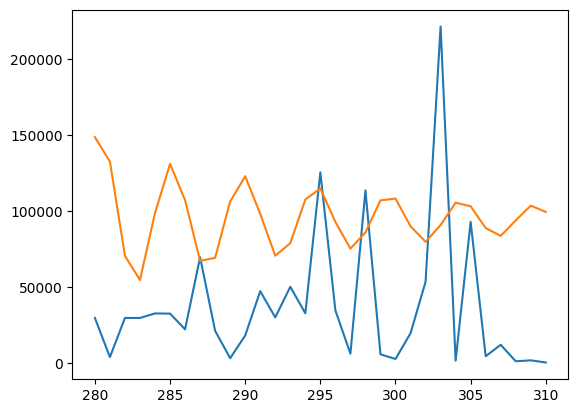

In [10]:
# use the auto model as a baseline as comparison
from pmdarima.arima import auto_arima

train = df['NUMBER RELEASED'][:280]
test = df['NUMBER RELEASED'][280:]

model = auto_arima(train, seasonal=True, trace=True)

predictions = model.predict(n_periods=len(df['NUMBER RELEASED'][280:]))

plt.plot(df['NUMBER RELEASED'][280:])
plt.plot(predictions)
print(model.summary())

In [11]:
np.sqrt(mean_squared_error(df['NUMBER RELEASED'][280:],predictions))

79100.72430594235

In [12]:
np.std(df['NUMBER RELEASED'][280:])

46141.748797905704

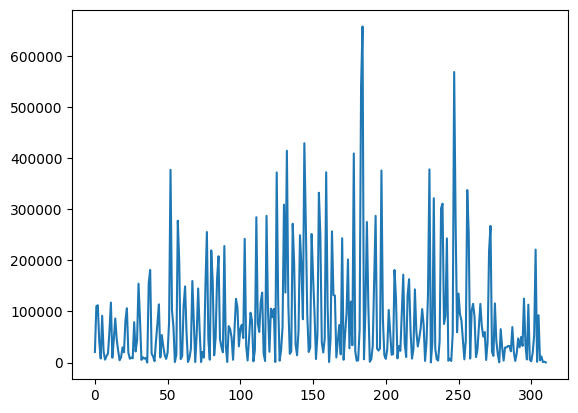

In [13]:
plt.plot(df['NUMBER RELEASED'])

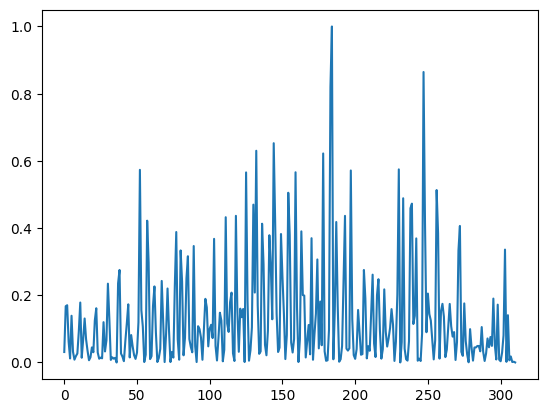

In [14]:
df['NUMBER RELEASED_standard'] = (df['NUMBER RELEASED'] - df['NUMBER RELEASED'].min()) / (df['NUMBER RELEASED'].max() - df['NUMBER RELEASED'].min()  )
plt.plot(df['NUMBER RELEASED_standard'])
# the outcome shows standarization is not a must

In [15]:
from scipy.stats import zscore

z_scores = zscore(df['NUMBER RELEASED'])

# Identify outliers (values with Z-scores > 3 or < -3)
outliers = (z_scores > 3) | (z_scores < -3)

# Display indices of outliers
print("Outliers found at indices:", df[outliers].index.tolist())

Outliers found at indices: [132, 144, 178, 183, 184, 247]


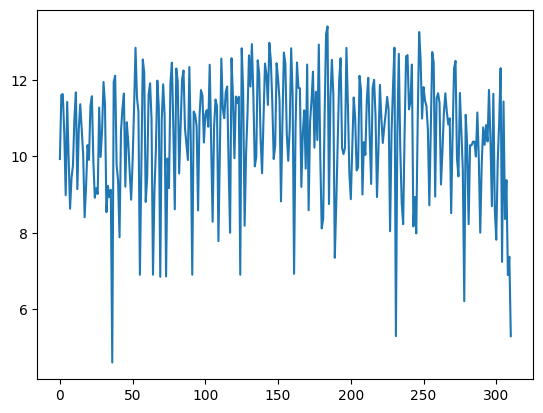

In [16]:
# Apply log transformation (add 1 to avoid log(0))
df['NUMBER RELEASED Log'] = np.log1p(df['NUMBER RELEASED'])

# Check the transformed data
plt.plot(df['NUMBER RELEASED Log'])

In [17]:
from scipy.stats import zscore

z_scores = zscore(df['NUMBER RELEASED Log'])

outliers = (z_scores > 3) | (z_scores < -3)

print("Outliers found at indices:", df[outliers].index.tolist())

Outliers found at indices: [36, 231, 310]


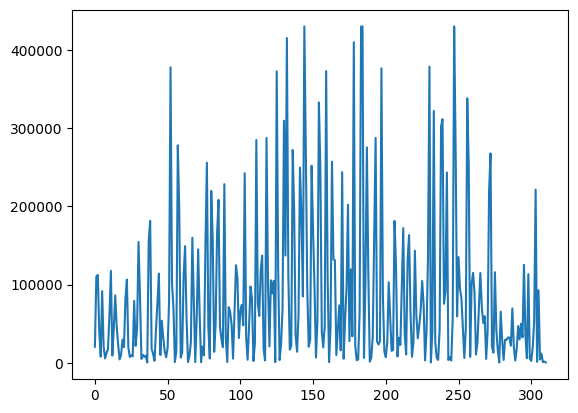

In [18]:
from scipy.stats.mstats import winsorize

# Winsorize the 'NUMBER RELEASED' column (1% from both tails as an example)
df['NUMBER RELEASED Winsorized'] = winsorize(df['NUMBER RELEASED'], limits=[0.01, 0.01])

# Check changes
plt.plot(df['NUMBER RELEASED Winsorized'])

In [19]:
from scipy.stats import zscore

z_scores = zscore(df['NUMBER RELEASED Winsorized'])

outliers = (z_scores > 3) | (z_scores < -3)

print("Outliers found at indices:", df[outliers].index.tolist())

Outliers found at indices: [132, 144, 178, 183, 184, 247]


In [20]:
# log performs better
df.drop('NUMBER RELEASED Winsorized',axis=1)

,COLLECTION_END_DATE,NUMBER RELEASED,salinity_MEAN_SCAL,FISH LENGTH (cm),FISH WEIGHT (g),temperature_MEAN_SCAL,currency_MEAN_SCAL,NUMBER RELEASED_standard,NUMBER RELEASED Log
0,1976-03-01,20586,17.527500,20.736000,119.960000,3.556667,131.500000,0.031117,9.932415
1,1976-04-01,110321,20.987727,18.577976,85.440476,3.919667,192.000000,0.167420,11.611159
2,1976-05-01,112260,15.752353,20.093636,101.436364,4.721923,221.250000,0.170365,11.628582
3,1976-06-01,40899,18.543500,20.502273,108.068182,5.693947,177.800000,0.061971,10.618885
4,1976-08-01,7998,24.311364,15.060000,49.600000,6.708814,195.632653,0.011997,8.987072
...,...,...,...,...,...,...,...,...,...
306,2015-11-01,4294,33.605556,25.000000,178.000000,6.788750,187.232044,0.006370,8.365207
307,2015-12-01,11856,32.438333,26.650000,195.600000,4.773750,189.677966,0.017857,9.380674
308,2016-01-01,992,32.373333,27.900000,322.500000,4.005000,188.926554,0.001355,6.900731
309,2016-04-01,1600,32.526842,24.100000,200.000000,0.381250,174.220339,0.002278,7.378384


Deciding SARIMA model hyperparameters

In [21]:
train = df['NUMBER RELEASED Log'][:280]
test = df['NUMBER RELEASED Log'][280:]

model = auto_arima(train, seasonal=True, trace=True)
predictions1 = model.predict(n_periods=len(df['NUMBER RELEASED Log'][280:]))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=987.192, Time=4.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1183.971, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1168.802, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1032.395, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1181.972, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=990.450, Time=1.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=983.479, Time=0.71 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=984.173, Time=0.70 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=984.286, Time=2.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=978.558, Time=7.88 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=977.792, Time=1.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=977.653, Time=4.71 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=988.314, 

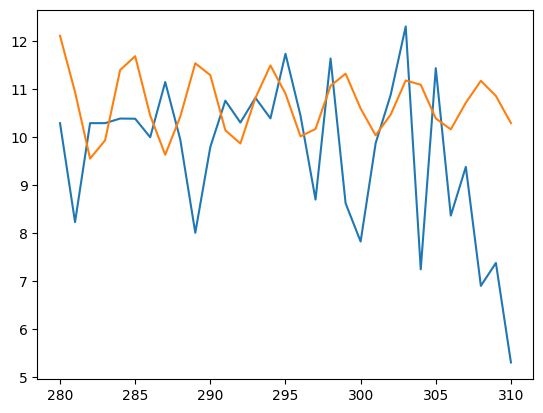

In [22]:
plt.plot(df['NUMBER RELEASED Log'][280:])
plt.plot(predictions1)

In [23]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(df['NUMBER RELEASED Log'][280:],predictions1)))
print(np.std(df['NUMBER RELEASED Log'][280:] - predictions1))

actual_exp = np.exp(df['NUMBER RELEASED Log'][280:])
predictions_exp = np.exp(predictions1)
rmse_original = np.sqrt(mean_squared_error(actual_exp, predictions_exp))
print(f"RMSE on Original Scale: {rmse_original}")

2.04246881172452
1.7498329731992586
RMSE on Original Scale: 60865.75386585717


In [24]:
# Convert 'Date' column to datetime
df['COLLECTION_END_DATE'] = pd.to_datetime(df['COLLECTION_END_DATE'])

# Sort DataFrame by date
df.sort_values(by='COLLECTION_END_DATE', inplace=True)

# Set 'Date' column as index
df.set_index('COLLECTION_END_DATE', inplace=True)

# Convert DataFrame to numpy array
data = df.values

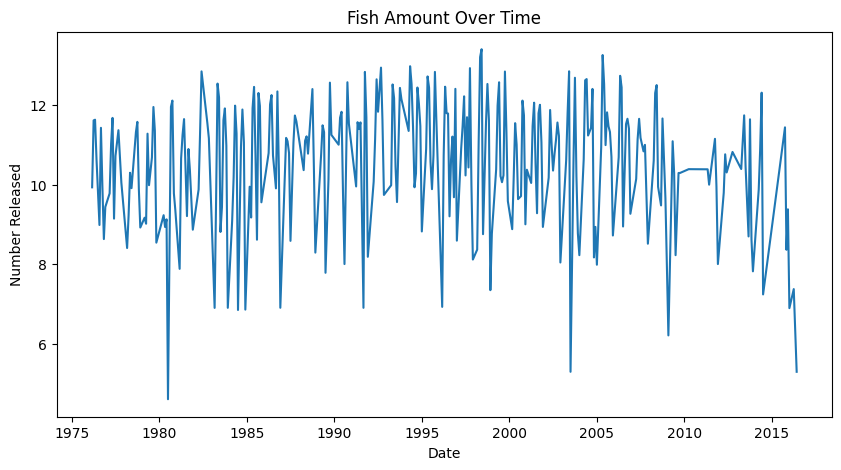

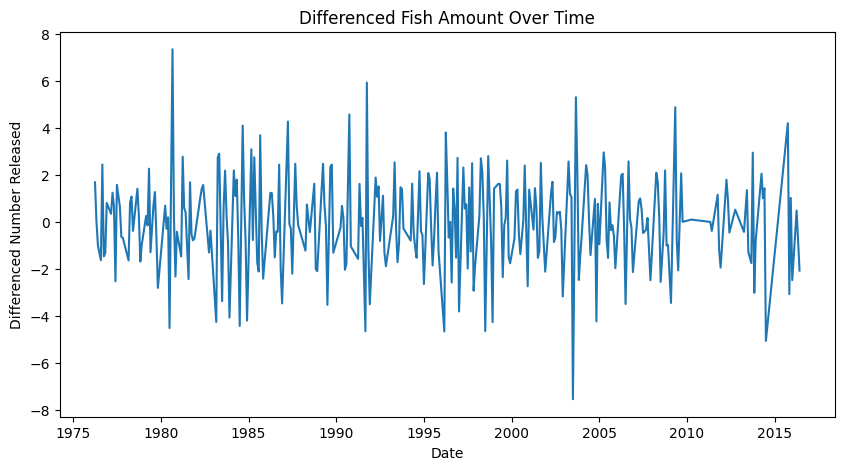

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fish_amount = df['NUMBER RELEASED Log']
# Plot the raw time series
plt.figure(figsize=(10, 5))
plt.plot(df.index, fish_amount)
plt.title('Fish Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Number Released')
plt.show()

# Check stationarity visually or using statistical tests (e.g., ADF test)
# If non-stationary, apply differencing
diff_fish_amount = fish_amount.diff().dropna()

# Plot differenced time series if needed
plt.figure(figsize=(10, 5))
plt.plot(df.index[1:], diff_fish_amount)
plt.title('Differenced Fish Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Number Released')
plt.show()

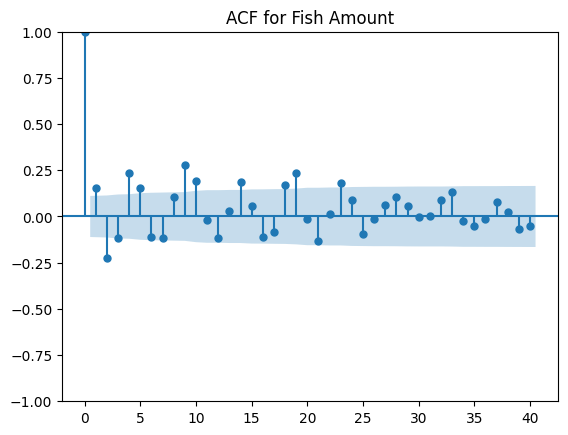

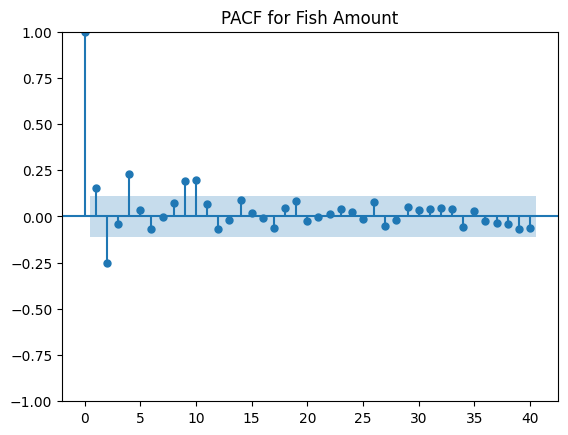

In [26]:
# Plot ACF
plot_acf(fish_amount, lags=40)
plt.title('ACF for Fish Amount')
plt.show()

# Plot PACF
plot_pacf(fish_amount, lags=40, method='ywm')
plt.title('PACF for Fish Amount')
plt.show()

In [27]:
# Normalize each column separately
scaler_salinity = MinMaxScaler(feature_range=(0, 1))
scaler_fish_length = MinMaxScaler(feature_range=(0, 1))
scaler_temperature = MinMaxScaler(feature_range=(0, 1))
scaler_currency = MinMaxScaler(feature_range=(0, 1))
scaler_fish_weight = MinMaxScaler(feature_range=(0, 1))
scaler_fish_amount = MinMaxScaler(feature_range=(0, 1))

In [28]:
# Define window size (number of time steps to look back)
window_size = 12

In [29]:
df = df[['NUMBER RELEASED Log', 'temperature_MEAN_SCAL', 'salinity_MEAN_SCAL', 'currency_MEAN_SCAL']]
df.columns = ['fish_amount', 'temperature', 'salinity', 'currency']

print(df.head())

                     fish_amount  temperature   salinity    currency
COLLECTION_END_DATE                                                 
1976-03-01              9.932415     3.556667  17.527500  131.500000
1976-04-01             11.611159     3.919667  20.987727  192.000000
1976-05-01             11.628582     4.721923  15.752353  221.250000
1976-06-01             10.618885     5.693947  18.543500  177.800000
1976-08-01              8.987072     6.708814  24.311364  195.632653


In [30]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['salinity', 'temperature', 'currency']])
scaled_df = pd.DataFrame(scaled_data, columns=['salinity', 'temperature', 'currency'])
scaled_df.index = df.index

In [31]:
X = df[['salinity', 'temperature', 'currency']]
y = df['fish_amount']
# train_size = 0.7 # 217
# val_size = 0.15  # 218-264
# test_size = 0.15 # 264-310

compare model performance

In [32]:
train_end = 217
val_start = 217
val_end = 264
test_start = 264

train_y = y[:train_end]
val_y = y[val_start:val_end]
test_y = y[test_start:]

train_exog = scaled_df[:train_end]
val_exog = scaled_df[val_start:val_end]
test_exog = scaled_df[test_start:]

In [33]:
p, d, q = 4, 1, 2
P, D, Q, s = 1, 1, 1, 12

In [34]:
# Fit SARIMA model
sarima_model = SARIMAX(
    train_y,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    exog=train_exog
)
fitted_model = sarima_model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [35]:
forecast = fitted_model.get_forecast(steps=len(val_y), exog=val_exog)
forecast_values_sarima = forecast.predicted_mean
conf_int = forecast.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [47]:
from prophet import Prophet
# no external variable model

# Prepare the training data for Prophet
train_prophet = pd.DataFrame({
    'ds': df.index[:train_end],
    'y': train_y
})

# Initialize and fit the Prophet model
model = Prophet(changepoint_prior_scale=0.05)
model.fit(train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgwysy_a3/6l4kwpcq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgwysy_a3/gb3yjvq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41300', 'data', 'file=/tmp/tmpgwysy_a3/6l4kwpcq.json', 'init=/tmp/tmpgwysy_a3/gb3yjvq4.json', 'output', 'file=/tmp/tmpgwysy_a3/prophet_modelwnh24lz2/prophet_model-20241118041021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:10:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:10:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [48]:
# Create a DataFrame with validation dates
val_dates = df.index[val_start:val_end]

# Predict using Prophet for validation dates
future_val = pd.DataFrame({'ds': val_dates})
forcast_values_prophet = model.predict(future_val)['yhat']

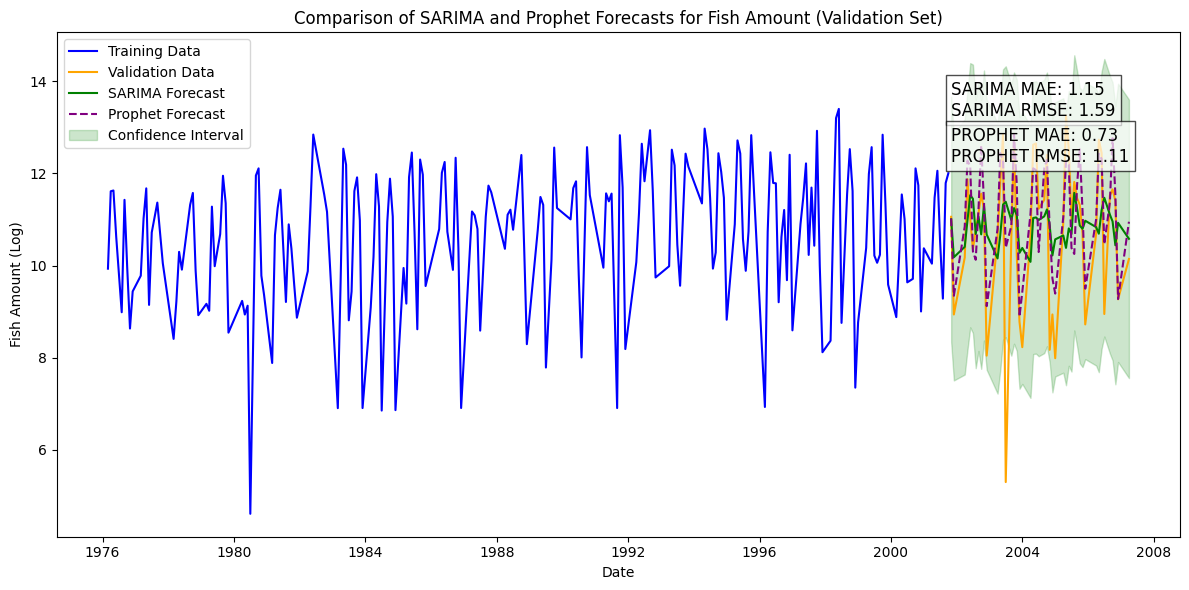

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.figure(figsize=(12, 6))

# Training Data
plt.plot(train_y.index, train_y, label='Training Data', color='blue')

# Validation Data
plt.plot(val_y.index, val_y, label='Validation Data', color='orange')

# SARIMA Forecast
plt.plot(val_y.index, forecast_values_sarima, label='SARIMA Forecast', color='green')

# Prophet Forecast
plt.plot(val_y.index, forcast_values_prophet, label='Prophet Forecast', color='purple', linestyle='--')

# Confidence Interval
plt.fill_between(
    val_y.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='green',
    alpha=0.2,
    label='Confidence Interval'
)


# Text for SARIMA Metrics
plt.text(
    val_y.index[0],
    max(val_y),
    f'SARIMA MAE: {sarima_mae:.2f}\nSARIMA RMSE: {sarima_rmse:.2f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.7)
)

plt.text(
    val_y.index[0],
    max(val_y) - 1,
    f'PROPHET MAE: {prophet_mae:.2f}\nPROPHET RMSE: {prophet_rmse:.2f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.7)
)

# Add titles and labels
plt.title('Comparison of SARIMA and Prophet Forecasts for Fish Amount (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Fish Amount (Log)')
plt.legend()
plt.tight_layout()
plt.show()

prophet model performs better so use prophet model to test and predict

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgwysy_a3/_bg7foqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgwysy_a3/pgjcutf8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61196', 'data', 'file=/tmp/tmpgwysy_a3/_bg7foqy.json', 'init=/tmp/tmpgwysy_a3/pgjcutf8.json', 'output', 'file=/tmp/tmpgwysy_a3/prophet_model5yk6zh49/prophet_model-20241118041032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:10:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:10:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


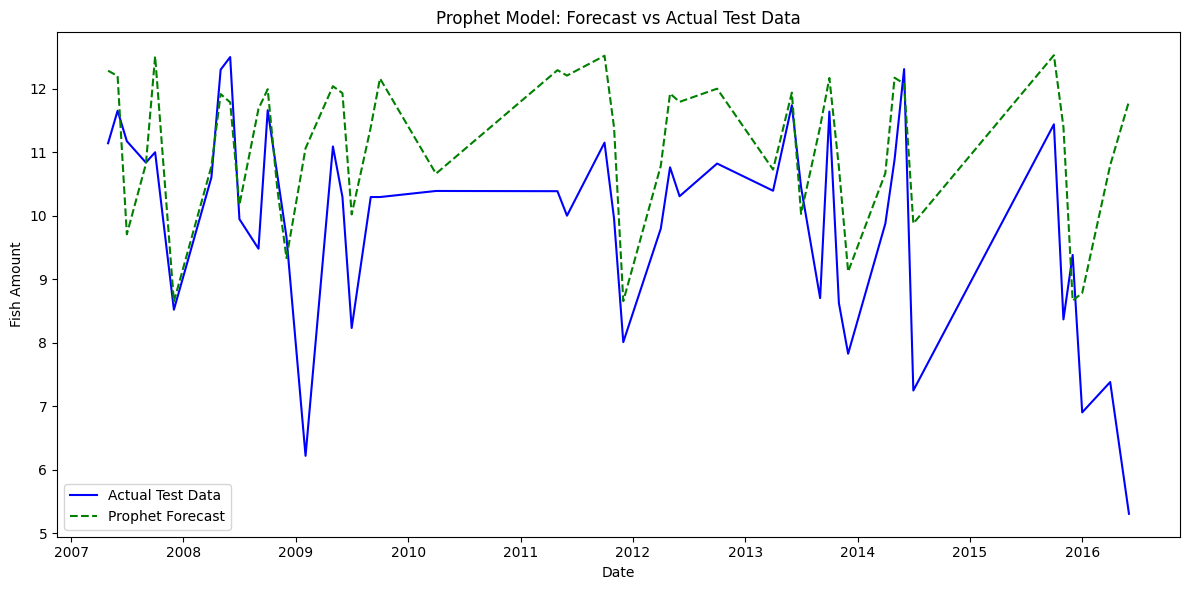

In [50]:
# Combine training and validation data
train_val_y = pd.concat([train_y, val_y])

# Create a DataFrame with combined training and validation dates
train_val_dates = df.index[:len(train_val_y)]
train_val_df = pd.DataFrame({'ds': train_val_dates, 'y': train_val_y})

# Train Prophet model on the combined data
model = Prophet()
model.fit(train_val_df)

# Create a DataFrame with test set dates for prediction
test_dates = df.index[test_start:]
test_df = pd.DataFrame({'ds': test_dates})

# Predict using the trained model
forecast = model.predict(test_df)

# Get the predicted values (yhat)
forecast_values_prophet = forecast['yhat']

plt.figure(figsize=(12, 6))

# Plot original test data
plt.plot(test_y.index, test_y, label='Actual Test Data', color='blue', linestyle='-')

# Plot Prophet forecasted data
plt.plot(test_y.index, forecast_values_prophet, label='Prophet Forecast', color='green', linestyle='--')

# Add titles and labels
plt.title('Prophet Model: Forecast vs Actual Test Data')
plt.xlabel('Date')
plt.ylabel('Fish Amount')
plt.legend()
plt.tight_layout()
plt.show()


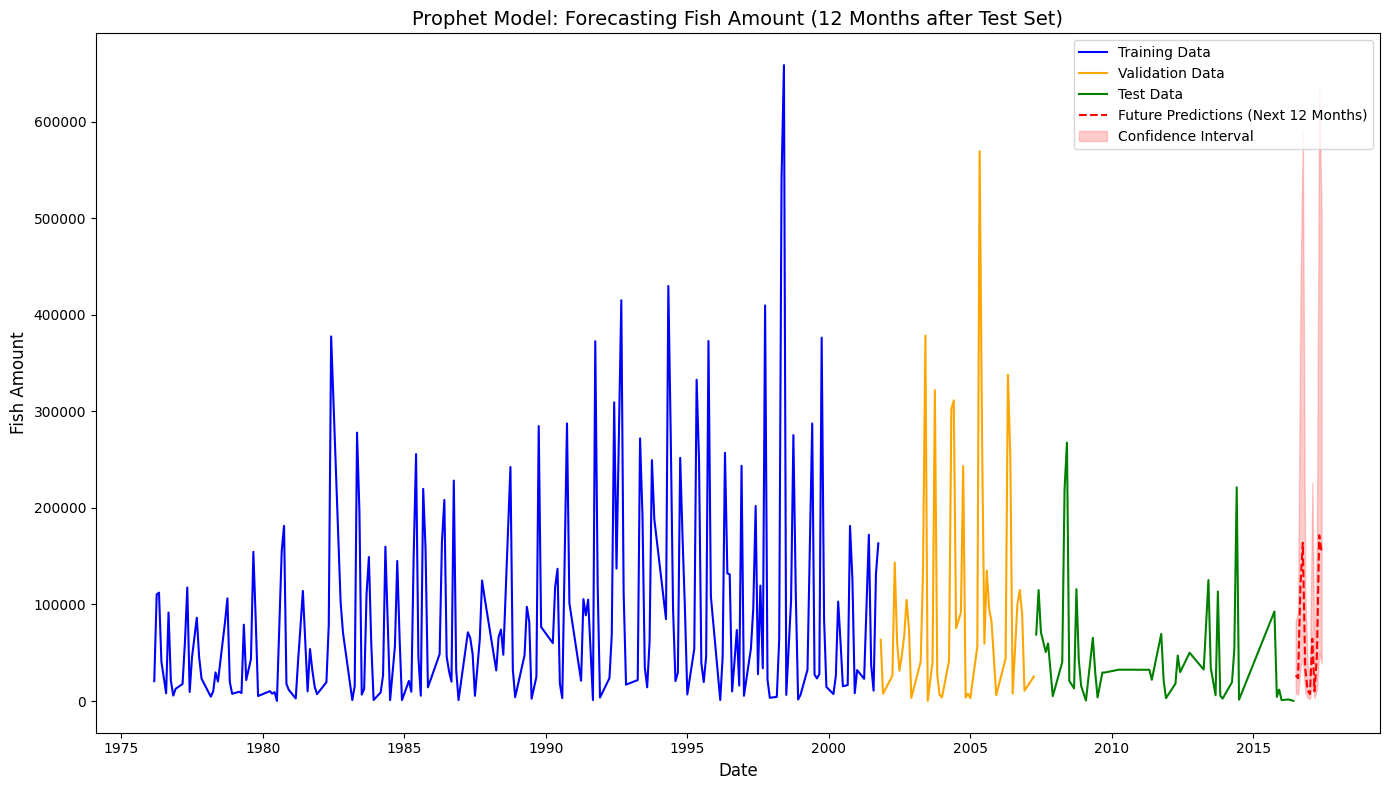

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get the last date from the test set
last_test_date = df.index[test_start + len(test_y) - 1]

# Generate future dates for prediction (next 12 months from the last test date)
future_dates = pd.date_range(start=last_test_date, periods=13, freq='MS')  # 13 months (last test month + 12 months)

# Prepare the future DataFrame for Prophet prediction (Prophet requires 'ds' column)
future_df = pd.DataFrame({'ds': future_dates})

# Generate future predictions using the fitted Prophet model
forecast_future = model.predict(future_df)

# Extract the predicted values
forecast_future_values = np.exp(forecast_future['yhat'])  # Convert from log scale to original values
forecast_future_upper = np.exp(forecast_future['yhat_upper'])  # Confidence interval upper bound
forecast_future_lower = np.exp(forecast_future['yhat_lower'])  # Confidence interval lower bound

# Plot the historical data (train, validation, and test)
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(train_y.index, np.exp(train_y), label='Training Data', color='blue', linestyle='-')

# Plot validation data
plt.plot(val_y.index, np.exp(val_y), label='Validation Data', color='orange', linestyle='-')

# Plot test data
plt.plot(test_y.index, np.exp(test_y), label='Test Data', color='green', linestyle='-')

# Plot Prophet future predictions (12 months ahead starting from the test set)
plt.plot(future_dates[1:], forecast_future_values[1:], label='Future Predictions (Next 12 Months)', color='red', linestyle='--')

# Plot the confidence interval for the future predictions
plt.fill_between(future_dates[1:], forecast_future_lower[1:], forecast_future_upper[1:], color='red', alpha=0.2, label='Confidence Interval')

# Add titles and labels
plt.title('Prophet Model: Forecasting Fish Amount (12 Months after Test Set)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Fish Amount', fontsize=12)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


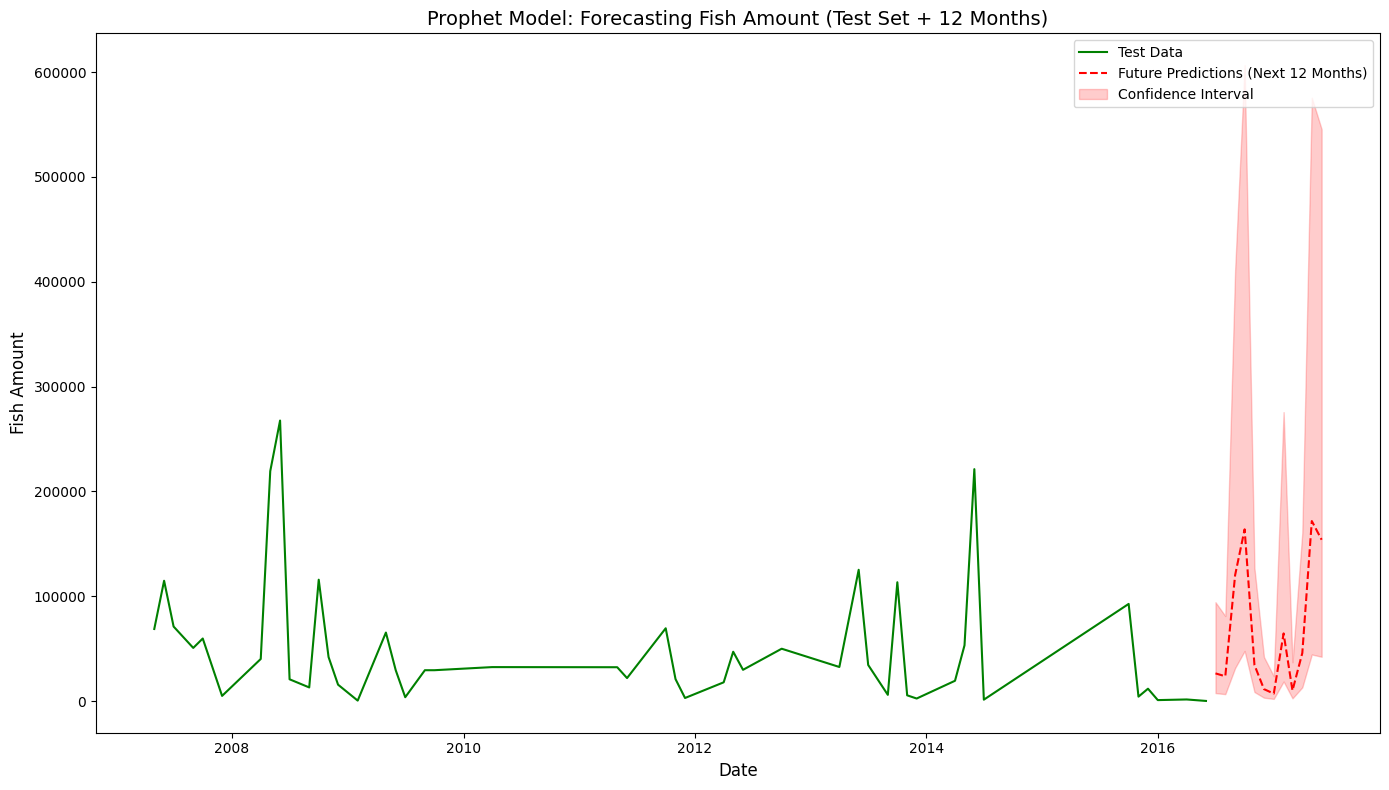

In [46]:
plt.figure(figsize=(14, 8))

# Plot test data
plt.plot(test_y.index, np.exp(test_y), label='Test Data', color='green', linestyle='-')

# Plot Prophet future predictions (12 months ahead starting from the test set)
plt.plot(future_dates[1:], forecast_future_values[1:], label='Future Predictions (Next 12 Months)', color='red', linestyle='--')

# Plot the confidence interval for the future predictions
plt.fill_between(future_dates[1:], forecast_future_lower[1:], forecast_future_upper[1:], color='red', alpha=0.2, label='Confidence Interval')

plt.title('Prophet Model: Forecasting Fish Amount (Test Set + 12 Months)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Fish Amount', fontsize=12)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

**2. Predicting fish length and width using SARIMA**

In [62]:
# reload the dataset
df = pd.read_excel('combine_in_out.xlsx')

In [63]:
# Normalize each column separately
scaler_salinity = MinMaxScaler(feature_range=(0, 1))
scaler_fish_length = MinMaxScaler(feature_range=(0, 1))
scaler_temperature = MinMaxScaler(feature_range=(0, 1))
scaler_currency = MinMaxScaler(feature_range=(0, 1))
scaler_fish_weight = MinMaxScaler(feature_range=(0, 1))
scaler_fish_amount = MinMaxScaler(feature_range=(0, 1))

# Apply scaling on the salinity and fish length columns separately
df['salinity_MEAN_SCAL'] = scaler_salinity.fit_transform(df[['salinity_MEAN_SCAL']])
#df['FISH LENGTH (cm)'] = scaler_fish_length.fit_transform(df[['FISH LENGTH (cm)']])
df['temperature_MEAN_SCAL'] = scaler_temperature.fit_transform(df[['temperature_MEAN_SCAL']])
df['currency_MEAN_SCAL'] = scaler_currency.fit_transform(df[['currency_MEAN_SCAL']])
#df['FISH WEIGHT (g)'] = scaler_fish_weight.fit_transform(df[['FISH WEIGHT (g)']])
#df['NUMBER RELEASED'] = scaler_fish_amount.fit_transform(df[['NUMBER RELEASED']])

# Convert DataFrame to numpy arrays for salinity and fish length
salinity_data = df['salinity_MEAN_SCAL'].values
fish_length_data = df['FISH LENGTH (cm)'].values
temperature_data = df['temperature_MEAN_SCAL'].values
currency_data = df['currency_MEAN_SCAL'].values
fish_weight_data = df['FISH WEIGHT (g)'].values
fish_amount_data = df['NUMBER RELEASED'].values


# Define window size (number of time steps to look back)
window_size = 12


Historical Data Statistics:
count     311.000000
mean      143.216994
std       124.813280
min         3.000000
25%        35.044118
50%       132.538462
75%       212.880435
max      1000.000000
Name: fish_weight, dtype: float64

Historical Data Range:
Min: 3.00
Max: 1000.00
Standard Deviation: 124.81

Historical Month-to-Month Changes:
Average change: -0.11
Max increase: 749.92
Max decrease: -977.44
Change standard deviation: 147.34


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmo


Forecast Statistics:
Forecast range: 147.81 to 272.36
Forecast standard deviation: 38.74
Average monthly change in forecast: 46.22


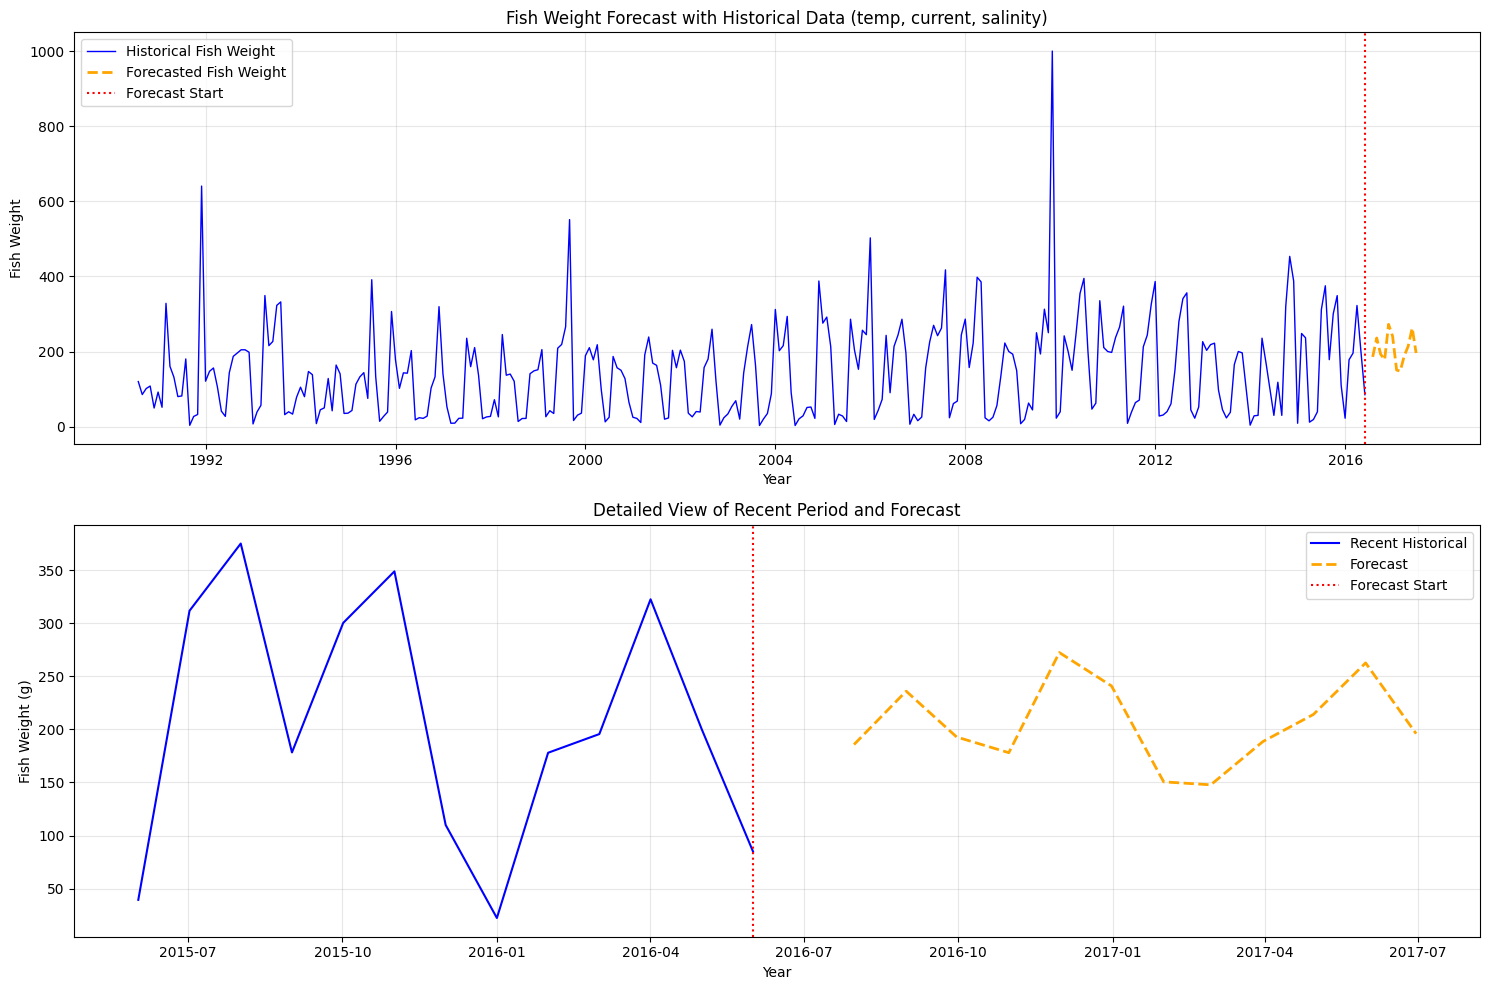


Forecasted values:
          Date  Forecasted_Fish_Weight
311 2016-07-31              185.728362
312 2016-08-31              235.979595
313 2016-09-30              192.828036
314 2016-10-31              178.048915
315 2016-11-30              272.356541
316 2016-12-31              240.926499
317 2017-01-31              150.596602
318 2017-02-28              147.805734
319 2017-03-31              188.578896
320 2017-04-30              214.096122
321 2017-05-31              262.585494
322 2017-06-30              195.972601


In [64]:
df = pd.DataFrame({
    'salinity': salinity_data,
    'temperature': temperature_data,
    'currency': currency_data,
    'fish_weight': fish_weight_data
})

# Calculate the correct start date based on 311 observations ending in June 2016
end_date = pd.to_datetime('2016-06-01')
start_date = end_date - pd.DateOffset(months=310)
df.index = pd.date_range(start=start_date, end=end_date, periods=311)

# Print historical data statistics
print("Historical Data Statistics:")
print(df['fish_weight'].describe())
print("\nHistorical Data Range:")
print(f"Min: {df['fish_weight'].min():.2f}")
print(f"Max: {df['fish_weight'].max():.2f}")
print(f"Standard Deviation: {df['fish_weight'].std():.2f}")

# Calculate month-to-month changes in historical data
historical_changes = df['fish_weight'].diff()
print("\nHistorical Month-to-Month Changes:")
print(f"Average change: {historical_changes.mean():.2f}")
print(f"Max increase: {historical_changes.max():.2f}")
print(f"Max decrease: {historical_changes.min():.2f}")
print(f"Change standard deviation: {historical_changes.std():.2f}")

# Try different ARIMA parameters
# Introduce seasonal component
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 12  # Seasonal component

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['salinity', 'temperature', 'currency']])
scaled_df = pd.DataFrame(scaled_data, columns=['salinity', 'temperature', 'currency'])
scaled_df.index = df.index


# Fit SARIMA model
sarima_model = SARIMAX(
    df['fish_weight'],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    exog=scaled_df[['salinity', 'temperature', 'currency']]
)
fitted_model = sarima_model.fit(disp=False)

# Create future exogenous variables with increased variation
future_periods = 12
np.random.seed(42)  # For reproducibility

# Add some seasonal variation to temperature with increased amplitude
seasonal_temp = df['temperature'].values[-12:]  # Use last year's pattern
future_temp = seasonal_temp + np.random.normal(0, df['temperature'].std()*0.3, 12)

future_exog = pd.DataFrame({
    'salinity': df['salinity'].values[-12:] + np.random.normal(0, df['salinity'].std()*0.3, 12),
    'temperature': future_temp,
    'currency': df['currency'].values[-12:] + np.random.normal(0, df['currency'].std()*0.3, 12)
})

# Scale future exogenous variables
scaler_exog = StandardScaler()
scaler_exog.fit(df[['salinity', 'temperature', 'currency']])
future_exog_scaled = scaler_exog.transform(future_exog)

# Generate forecast
forecast = fitted_model.forecast(steps=future_periods, exog=future_exog_scaled)
fish_weight_forecast = forecast

# Generate future dates
date_range = pd.date_range(start='2016-07-01', periods=len(fish_weight_forecast), freq='M')

# Print forecast statistics
print("\nForecast Statistics:")
forecast_changes = np.diff(fish_weight_forecast)
print(f"Forecast range: {fish_weight_forecast.min():.2f} to {fish_weight_forecast.max():.2f}")
print(f"Forecast standard deviation: {np.std(fish_weight_forecast):.2f}")
print(f"Average monthly change in forecast: {np.mean(np.abs(forecast_changes)):.2f}")

# Create enhanced visualization
plt.figure(figsize=(15, 10))

# Create subplot for the main forecast
plt.subplot(2, 1, 1)
plt.plot(df.index, df['fish_weight'], label='Historical Fish Weight',
         color='blue', linewidth=1)
plt.plot(date_range, fish_weight_forecast, label='Forecasted Fish Weight',
         color='orange', linewidth=2, linestyle='--')
plt.axvline(x=pd.to_datetime('2016-06-01'), color='red', linestyle=':',
            label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Fish Weight')
plt.title('Fish Weight Forecast with Historical Data (temp, current, salinity)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Create subplot for the recent period
plt.subplot(2, 1, 2)
recent_start = pd.to_datetime('2015-06-01')  # Show last year of historical data
plt.plot(df[df.index >= recent_start].index, df[df.index >= recent_start]['fish_weight'],
         label='Recent Historical', color='blue', linewidth=1.5)
plt.plot(date_range, fish_weight_forecast, label='Forecast',
         color='orange', linewidth=2, linestyle='--')
plt.axvline(x=pd.to_datetime('2016-06-01'), color='red', linestyle=':',
            label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Fish Weight (g)')
plt.title('Detailed View of Recent Period and Forecast')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print the forecasted values
forecast_df = pd.DataFrame({
    'Date': date_range,
    'Forecasted_Fish_Weight': fish_weight_forecast
})
print("\nForecasted values:")
print(forecast_df.to_string())

Historical Data Statistics:
count    311.000000
mean      18.808238
std        8.320842
min        3.000000
25%       13.600000
50%       19.311111
75%       23.181445
max      124.575000
Name: fish_length, dtype: float64

Historical Data Range:
Min: 3.00
Max: 124.58
Standard Deviation: 8.32

Historical Month-to-Month Changes:
Average change: 0.01
Max increase: 108.39
Max decrease: -100.26
Change standard deviation: 10.41


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat


Forecast Statistics:
Forecast range: 17.38 to 27.89
Forecast standard deviation: 2.58
Average monthly change in forecast: 2.32


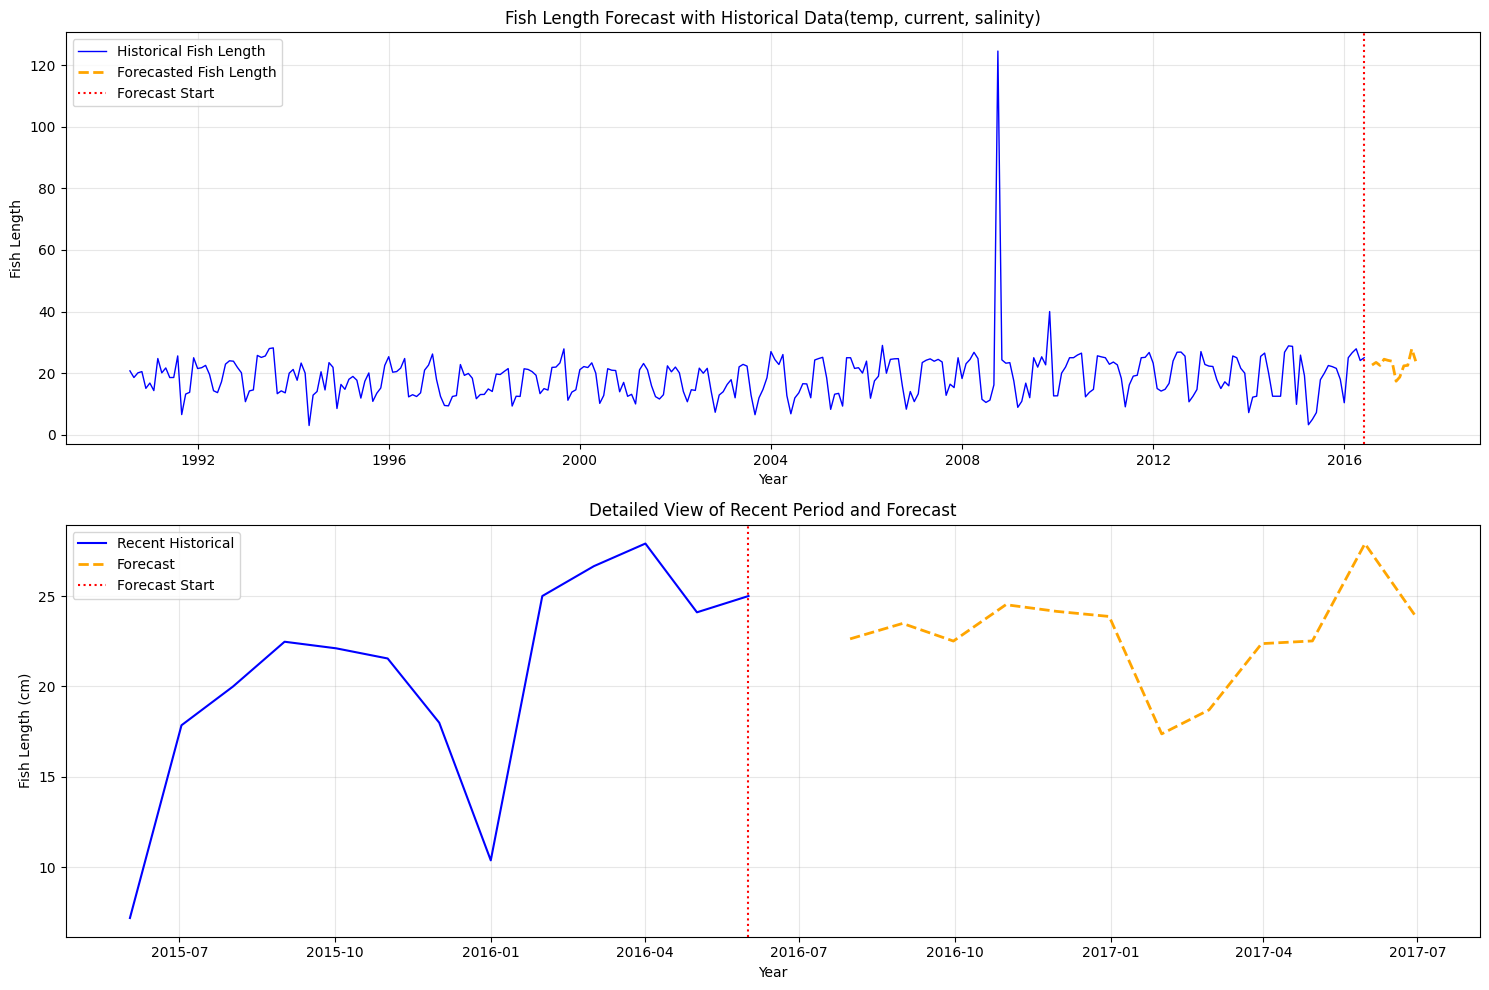


Forecasted values:
          Date  Forecasted_Fish_Length
311 2016-07-31               22.631427
312 2016-08-31               23.485075
313 2016-09-30               22.511104
314 2016-10-31               24.521375
315 2016-11-30               24.151010
316 2016-12-31               23.871083
317 2017-01-31               17.379690
318 2017-02-28               18.710349
319 2017-03-31               22.368510
320 2017-04-30               22.517415
321 2017-05-31               27.892323
322 2017-06-30               23.873686


In [65]:
# Combine data into a DataFrame for easier handling
df = pd.DataFrame({
    'salinity': salinity_data,
    'temperature': temperature_data,
    'currency': currency_data,
    'fish_length': fish_length_data
})

# Calculate the correct start date based on 311 observations ending in June 2016
end_date = pd.to_datetime('2016-06-01')
start_date = end_date - pd.DateOffset(months=310)
df.index = pd.date_range(start=start_date, end=end_date, periods=311)

# Print historical data statistics
print("Historical Data Statistics:")
print(df['fish_length'].describe())
print("\nHistorical Data Range:")
print(f"Min: {df['fish_length'].min():.2f}")
print(f"Max: {df['fish_length'].max():.2f}")
print(f"Standard Deviation: {df['fish_length'].std():.2f}")

# Calculate month-to-month changes in historical data
historical_changes = df['fish_length'].diff()
print("\nHistorical Month-to-Month Changes:")
print(f"Average change: {historical_changes.mean():.2f}")
print(f"Max increase: {historical_changes.max():.2f}")
print(f"Max decrease: {historical_changes.min():.2f}")
print(f"Change standard deviation: {historical_changes.std():.2f}")

# Try different ARIMA parameters
# Introduce seasonal component
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 12  # Seasonal component

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['salinity', 'temperature', 'currency']])
scaled_df = pd.DataFrame(scaled_data, columns=['salinity', 'temperature', 'currency'])
scaled_df.index = df.index


# Fit SARIMA model
sarima_model = SARIMAX(
    df['fish_length'],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    exog=scaled_df[['salinity', 'temperature', 'currency']]
)
fitted_model = sarima_model.fit(disp=False)

# Create future exogenous variables with increased variation
future_periods = 12
np.random.seed(42)  # For reproducibility

# Add some seasonal variation to temperature with increased amplitude
seasonal_temp = df['temperature'].values[-12:]  # Use last year's pattern
future_temp = seasonal_temp + np.random.normal(0, df['temperature'].std()*0.3, 12)

future_exog = pd.DataFrame({
    'salinity': df['salinity'].values[-12:] + np.random.normal(0, df['salinity'].std()*0.3, 12),
    'temperature': future_temp,
    'currency': df['currency'].values[-12:] + np.random.normal(0, df['currency'].std()*0.3, 12)
})

# Scale future exogenous variables
scaler_exog = StandardScaler()
scaler_exog.fit(df[['salinity', 'temperature', 'currency']])
future_exog_scaled = scaler_exog.transform(future_exog)

# Generate forecast
forecast = fitted_model.forecast(steps=future_periods, exog=future_exog_scaled)
fish_length_forecast = forecast

# Generate future dates
date_range = pd.date_range(start='2016-07-01', periods=len(fish_length_forecast), freq='M')

# Print forecast statistics
print("\nForecast Statistics:")
forecast_changes = np.diff(fish_length_forecast)
print(f"Forecast range: {fish_length_forecast.min():.2f} to {fish_length_forecast.max():.2f}")
print(f"Forecast standard deviation: {np.std(fish_length_forecast):.2f}")
print(f"Average monthly change in forecast: {np.mean(np.abs(forecast_changes)):.2f}")

# Create enhanced visualization
plt.figure(figsize=(15, 10))

# Create subplot for the main forecast
plt.subplot(2, 1, 1)
plt.plot(df.index, df['fish_length'], label='Historical Fish Length',
         color='blue', linewidth=1)
plt.plot(date_range, fish_length_forecast, label='Forecasted Fish Length',
         color='orange', linewidth=2, linestyle='--')
plt.axvline(x=pd.to_datetime('2016-06-01'), color='red', linestyle=':',
            label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Fish Length')
plt.title('Fish Length Forecast with Historical Data(temp, current, salinity)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Create subplot for the recent period
plt.subplot(2, 1, 2)
recent_start = pd.to_datetime('2015-06-01')  # Show last year of historical data
plt.plot(df[df.index >= recent_start].index, df[df.index >= recent_start]['fish_length'],
         label='Recent Historical', color='blue', linewidth=1.5)
plt.plot(date_range, fish_length_forecast, label='Forecast',
         color='orange', linewidth=2, linestyle='--')
plt.axvline(x=pd.to_datetime('2016-06-01'), color='red', linestyle=':',
            label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Fish Length (cm)')
plt.title('Detailed View of Recent Period and Forecast')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print the forecasted values
forecast_df = pd.DataFrame({
    'Date': date_range,
    'Forecasted_Fish_Length': fish_length_forecast
})
print("\nForecasted values:")
print(forecast_df.to_string())

see whether temperature itself can have the equavelent effect on fish length and width compared to previous 3 factors considered together

Historical Data Statistics:
count    311.000000
mean      18.808238
std        8.320842
min        3.000000
25%       13.600000
50%       19.311111
75%       23.181445
max      124.575000
Name: fish_length, dtype: float64

Historical Data Range:
Min: 3.00
Max: 124.58
Standard Deviation: 8.32

Historical Month-to-Month Changes:
Average change: 0.01
Max increase: 108.39
Max decrease: -100.26
Change standard deviation: 10.41


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python


Forecast Statistics:
Forecast range: 17.20 to 27.74
Forecast standard deviation: 2.62
Average monthly change in forecast: 2.43


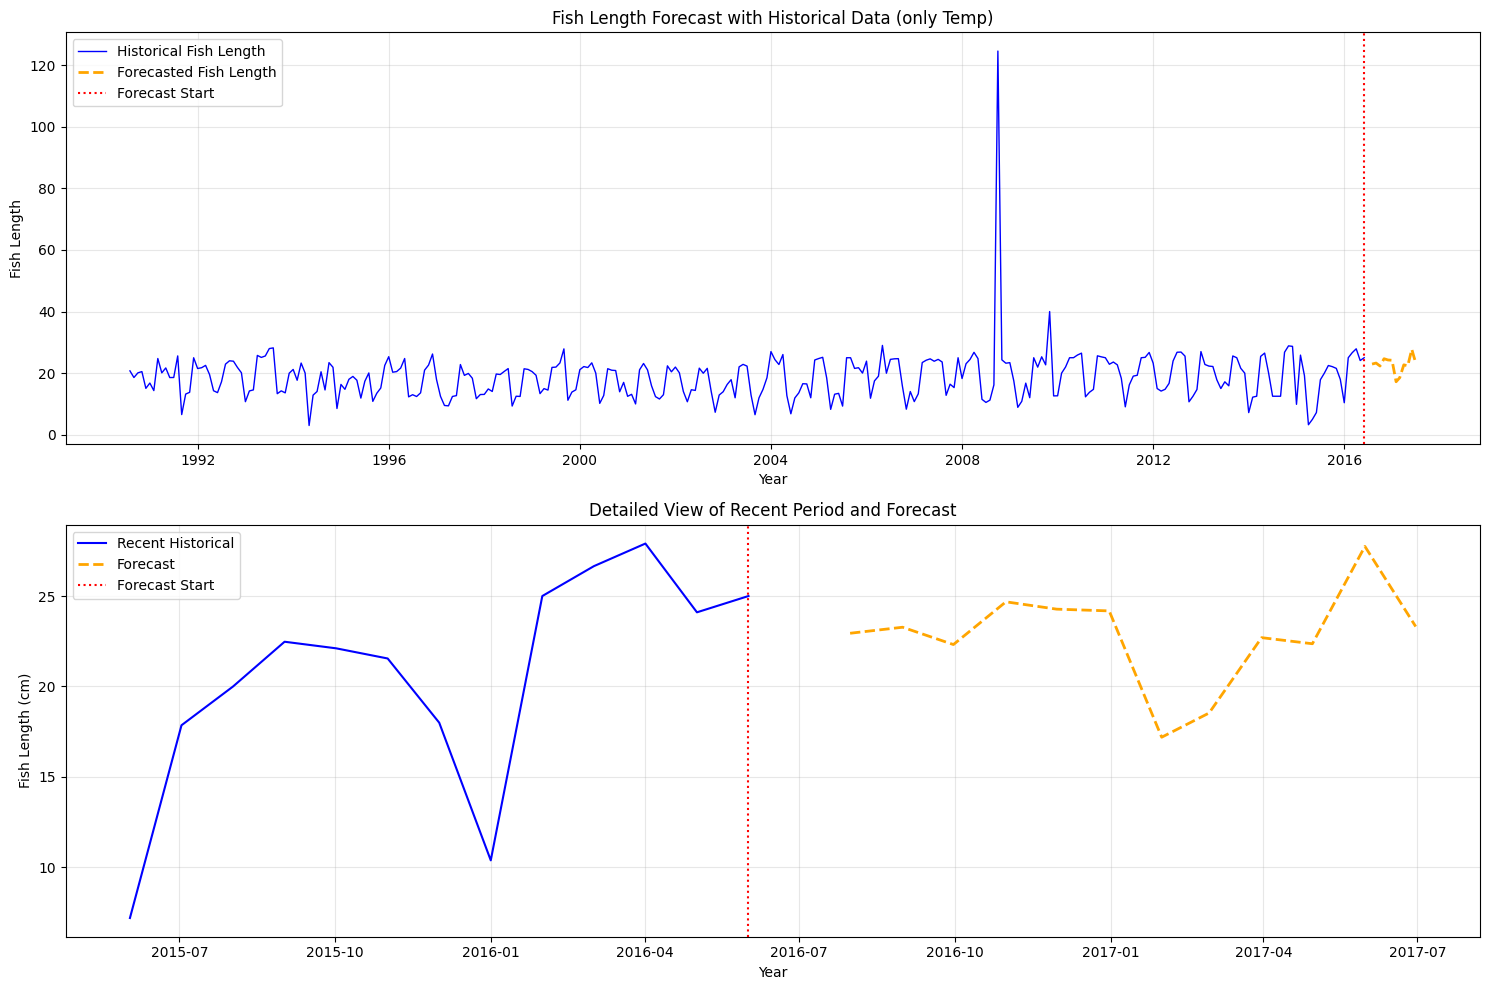


Forecasted values:
          Date  Forecasted_Fish_Length (only Temp)
311 2016-07-31                           22.942423
312 2016-08-31                           23.275294
313 2016-09-30                           22.318165
314 2016-10-31                           24.679514
315 2016-11-30                           24.274188
316 2016-12-31                           24.178067
317 2017-01-31                           17.197114
318 2017-02-28                           18.535465
319 2017-03-31                           22.699329
320 2017-04-30                           22.362398
321 2017-05-31                           27.742269
322 2017-06-30                           23.313402


In [67]:
# Combine data into a DataFrame for easier handling
df = pd.DataFrame({
    'temperature': temperature_data,
    'fish_length': fish_length_data
})

# Calculate the correct start date based on 311 observations ending in June 2016
end_date = pd.to_datetime('2016-06-01')
start_date = end_date - pd.DateOffset(months=310)
df.index = pd.date_range(start=start_date, end=end_date, periods=311)

# Print historical data statistics
print("Historical Data Statistics:")
print(df['fish_length'].describe())
print("\nHistorical Data Range:")
print(f"Min: {df['fish_length'].min():.2f}")
print(f"Max: {df['fish_length'].max():.2f}")
print(f"Standard Deviation: {df['fish_length'].std():.2f}")

# Calculate month-to-month changes in historical data
historical_changes = df['fish_length'].diff()
print("\nHistorical Month-to-Month Changes:")
print(f"Average change: {historical_changes.mean():.2f}")
print(f"Max increase: {historical_changes.max():.2f}")
print(f"Max decrease: {historical_changes.min():.2f}")
print(f"Change standard deviation: {historical_changes.std():.2f}")

# Try different ARIMA parameters
# Introduce seasonal component
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 12  # Seasonal component

# Scale the temperature data
scaler = StandardScaler()
scaled_temp = scaler.fit_transform(df[['temperature']])
scaled_df = pd.DataFrame(scaled_temp, columns=['temperature'])
scaled_df.index = df.index

# Fit SARIMA model
sarima_model = SARIMAX(
    df['fish_length'],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    exog=scaled_df
)
fitted_model = sarima_model.fit(disp=False)

# Create future exogenous variables with increased variation
future_periods = 12
np.random.seed(42)  # For reproducibility

# Add some seasonal variation to temperature with increased amplitude
seasonal_temp = df['temperature'].values[-12:]  # Use last year's pattern
future_temp = seasonal_temp + np.random.normal(0, df['temperature'].std() * 0.3, 12)

future_exog = pd.DataFrame({
    'temperature': future_temp
})

# Scale future exogenous variables
scaler_exog = StandardScaler()
scaler_exog.fit(df[['temperature']])
future_exog_scaled = scaler_exog.transform(future_exog)

# Generate forecast
forecast = fitted_model.forecast(steps=future_periods, exog=future_exog_scaled)
fish_length_forecast = forecast

# Generate future dates
date_range = pd.date_range(start='2016-07-01', periods=len(fish_length_forecast), freq='M')

# Print forecast statistics
print("\nForecast Statistics:")
forecast_changes = np.diff(fish_length_forecast)
print(f"Forecast range: {fish_length_forecast.min():.2f} to {fish_length_forecast.max():.2f}")
print(f"Forecast standard deviation: {np.std(fish_length_forecast):.2f}")
print(f"Average monthly change in forecast: {np.mean(np.abs(forecast_changes)):.2f}")

# Create enhanced visualization
plt.figure(figsize=(15, 10))

# Create subplot for the main forecast
plt.subplot(2, 1, 1)
plt.plot(df.index, df['fish_length'], label='Historical Fish Length',
         color='blue', linewidth=1)
plt.plot(date_range, fish_length_forecast, label='Forecasted Fish Length',
         color='orange', linewidth=2, linestyle='--')
plt.axvline(x=pd.to_datetime('2016-06-01'), color='red', linestyle=':',
            label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Fish Length')
plt.title('Fish Length Forecast with Historical Data (only Temp)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Create subplot for the recent period
plt.subplot(2, 1, 2)
recent_start = pd.to_datetime('2015-06-01')  # Show last year of historical data
plt.plot(df[df.index >= recent_start].index, df[df.index >= recent_start]['fish_length'],
         label='Recent Historical', color='blue', linewidth=1.5)
plt.plot(date_range, fish_length_forecast, label='Forecast',
         color='orange', linewidth=2, linestyle='--')
plt.axvline(x=pd.to_datetime('2016-06-01'), color='red', linestyle=':',
            label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Fish Length (cm)')
plt.title('Detailed View of Recent Period and Forecast')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print the forecasted values
forecast_df = pd.DataFrame({
    'Date': date_range,
    'Forecasted_Fish_Length (only Temp)': fish_length_forecast
})
print("\nForecasted values:")
print(forecast_df.to_string())


Historical Data Statistics:
count     311.000000
mean      143.216994
std       124.813280
min         3.000000
25%        35.044118
50%       132.538462
75%       212.880435
max      1000.000000
Name: fish_weight, dtype: float64

Historical Data Range:
Min: 3.00
Max: 1000.00
Standard Deviation: 124.81

Historical Month-to-Month Changes:
Average change: -0.11
Max increase: 749.92
Max decrease: -977.44
Change standard deviation: 147.34


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-pack


Forecast Statistics:
Forecast range: 147.48 to 277.34
Forecast standard deviation: 39.62
Average monthly change in forecast: 46.21


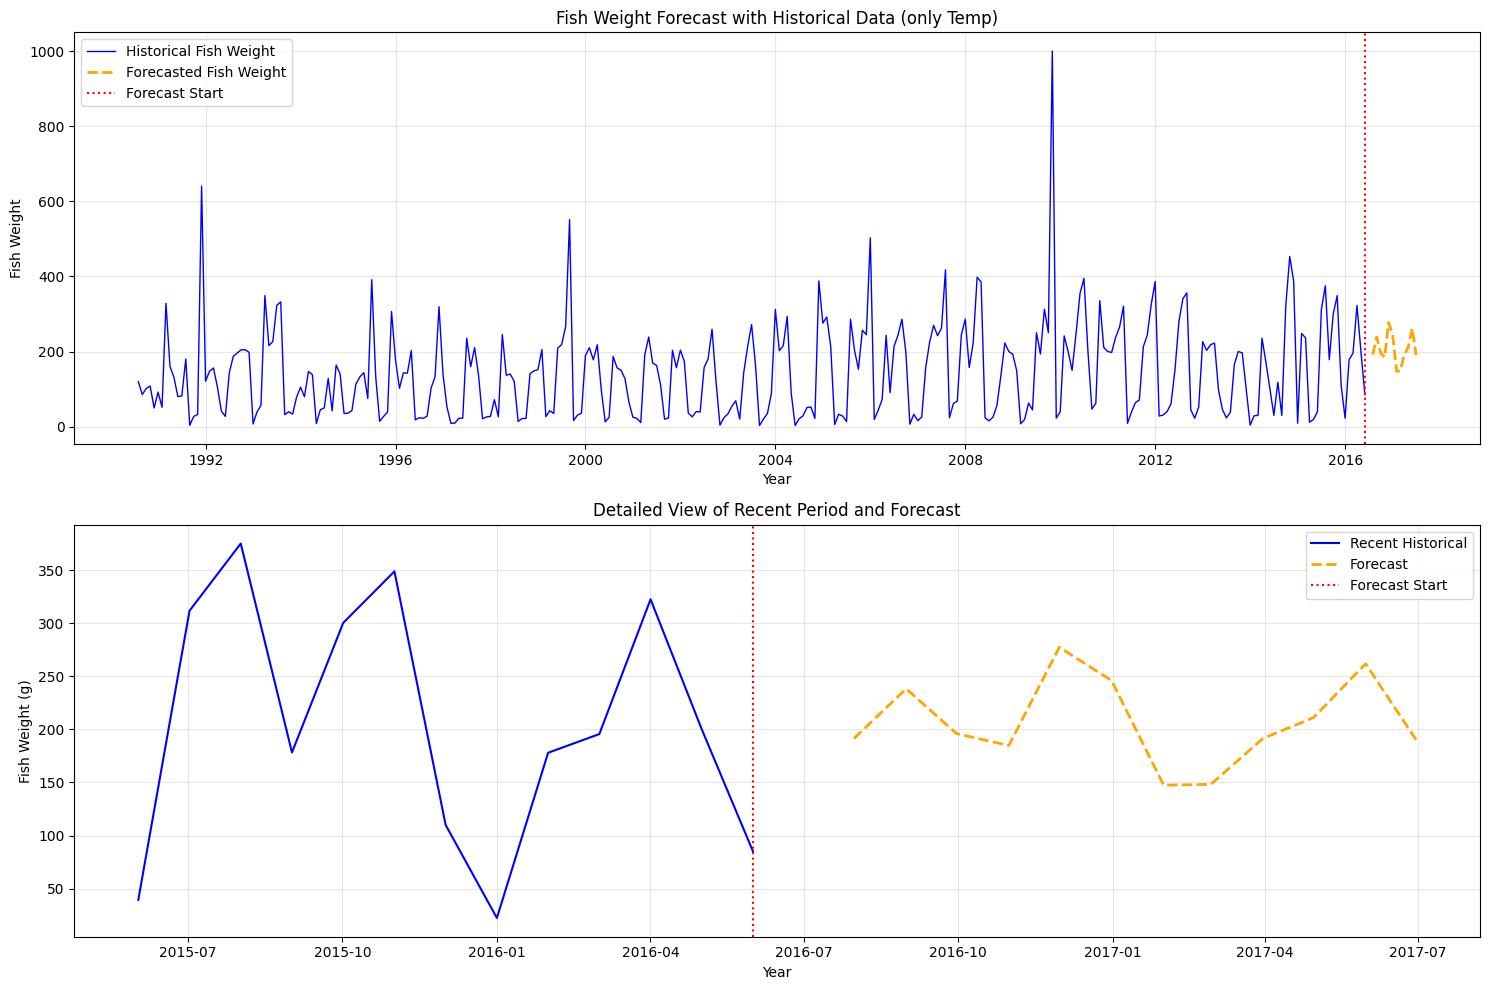


Forecasted values:
          Date  Forecasted_Fish_Weight(only Temp)
311 2016-07-31                         191.472646
312 2016-08-31                         238.227106
313 2016-09-30                         195.995784
314 2016-10-31                         184.847229
315 2016-11-30                         277.339899
316 2016-12-31                         246.063849
317 2017-01-31                         147.475141
318 2017-02-28                         148.248879
319 2017-03-31                         191.463454
320 2017-04-30                         211.034557
321 2017-05-31                         261.779015
322 2017-06-30                         190.248217


In [68]:
# Combine data into a DataFrame for easier handling
df = pd.DataFrame({
    'temperature': temperature_data,
    'fish_weight': fish_weight_data
})

# Calculate the correct start date based on 311 observations ending in June 2016
end_date = pd.to_datetime('2016-06-01')
start_date = end_date - pd.DateOffset(months=310)
df.index = pd.date_range(start=start_date, end=end_date, periods=311)

# Print historical data statistics
print("Historical Data Statistics:")
print(df['fish_weight'].describe())
print("\nHistorical Data Range:")
print(f"Min: {df['fish_weight'].min():.2f}")
print(f"Max: {df['fish_weight'].max():.2f}")
print(f"Standard Deviation: {df['fish_weight'].std():.2f}")

# Calculate month-to-month changes in historical data
historical_changes = df['fish_weight'].diff()
print("\nHistorical Month-to-Month Changes:")
print(f"Average change: {historical_changes.mean():.2f}")
print(f"Max increase: {historical_changes.max():.2f}")
print(f"Max decrease: {historical_changes.min():.2f}")
print(f"Change standard deviation: {historical_changes.std():.2f}")

# Try different ARIMA parameters
# Introduce seasonal component
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 12  # Seasonal component

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['temperature']])
scaled_df = pd.DataFrame(scaled_data, columns=['temperature'])
scaled_df.index = df.index

# Fit SARIMA model
sarima_model = SARIMAX(
    df['fish_weight'],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    exog=scaled_df[['temperature']]
)
fitted_model = sarima_model.fit(disp=False)

# Create future exogenous variables with increased variation
future_periods = 12
np.random.seed(42)  # For reproducibility

# Add some seasonal variation to temperature with increased amplitude
seasonal_temp = df['temperature'].values[-12:]  # Use last year's pattern
future_temp = seasonal_temp + np.random.normal(0, df['temperature'].std() * 0.3, 12)

future_exog = pd.DataFrame({
    'temperature': future_temp
})

# Scale future exogenous variables
scaler_exog = StandardScaler()
scaler_exog.fit(df[['temperature']])
future_exog_scaled = scaler_exog.transform(future_exog)

# Generate forecast
forecast = fitted_model.forecast(steps=future_periods, exog=future_exog_scaled)
fish_weight_forecast = forecast

# Generate future dates
date_range = pd.date_range(start='2016-07-01', periods=len(fish_weight_forecast), freq='M')

# Print forecast statistics
print("\nForecast Statistics:")
forecast_changes = np.diff(fish_weight_forecast)
print(f"Forecast range: {fish_weight_forecast.min():.2f} to {fish_weight_forecast.max():.2f}")
print(f"Forecast standard deviation: {np.std(fish_weight_forecast):.2f}")
print(f"Average monthly change in forecast: {np.mean(np.abs(forecast_changes)):.2f}")

# Create enhanced visualization
plt.figure(figsize=(15, 10))

# Create subplot for the main forecast
plt.subplot(2, 1, 1)
plt.plot(df.index, df['fish_weight'], label='Historical Fish Weight',
         color='blue', linewidth=1)
plt.plot(date_range, fish_weight_forecast, label='Forecasted Fish Weight',
         color='orange', linewidth=2, linestyle='--')
plt.axvline(x=pd.to_datetime('2016-06-01'), color='red', linestyle=':',
            label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Fish Weight')
plt.title('Fish Weight Forecast with Historical Data (only Temp)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Create subplot for the recent period
plt.subplot(2, 1, 2)
recent_start = pd.to_datetime('2015-06-01')  # Show last year of historical data
plt.plot(df[df.index >= recent_start].index, df[df.index >= recent_start]['fish_weight'],
         label='Recent Historical', color='blue', linewidth=1.5)
plt.plot(date_range, fish_weight_forecast, label='Forecast',
         color='orange', linewidth=2, linestyle='--')
plt.axvline(x=pd.to_datetime('2016-06-01'), color='red', linestyle=':',
            label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Fish Weight (g)')
plt.title('Detailed View of Recent Period and Forecast')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print the forecasted values
forecast_df = pd.DataFrame({
    'Date': date_range,
    'Forecasted_Fish_Weight(only Temp)': fish_weight_forecast
})
print("\nForecasted values:")
print(forecast_df.to_string())


as seen on the graph and forecasted values, temperature itself has a great weight in affecting fish length and width